Gradient Boosting Regrssor model is creating in this code to predict stocks target rates for future. GB model uses desicion trees.

In [69]:
# Importing dependencies
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")


Creating a Function to iterate through 5 stocks 

In [70]:
# list of stocks 
tickers= ['SHOP','KO','MDLZ','AAPL']

In [71]:
# Download historical data for the selected stocks
data = yf.download(tickers, start='2010-01-01', end=datetime.now())['Close']
data.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,KO,MDLZ,SHOP
Date,,,,
2010-01-04,7.643214,28.520000,27.430000,NaN
2010-01-05,7.656429,28.174999,28.770000,NaN
2010-01-06,7.534643,28.165001,28.969999,NaN
2010-01-07,7.520714,28.094999,28.900000,NaN
2010-01-08,7.570714,27.575001,28.930000,NaN


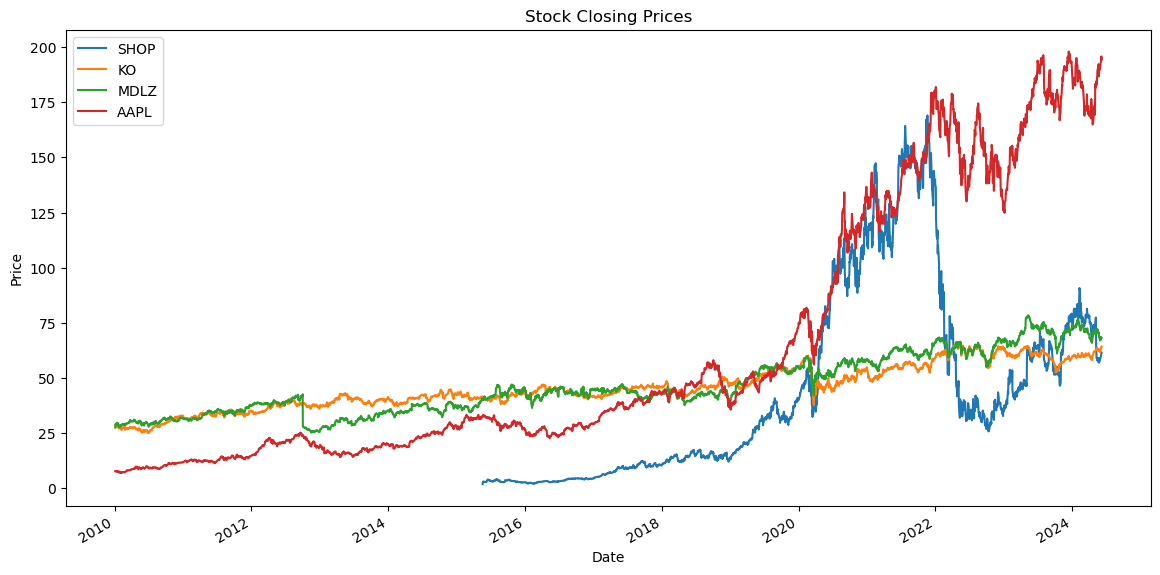

In [72]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
for ticker in tickers:
    data[ticker].plot(label=ticker)
plt.title('Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Above mentioned findings depicts that from 2010 - 2019 there is approx a straight without any curse making it not very relevant for Ml model to learn the trends. So, if we take data from 2010 - 2024 and split by 50/50 it will be a very bad model. So it is better to change the starting point from 2010 to 2020 and split 90/10 so that GBF model can learn and perform better.

In [73]:
# Calculate daily returns
# # Daily Return= 
# Price on Day (t−1)
# Price on Day t−Price on Day (t−1)
# ​
returns = data.pct_change()
returns.dropna()

Ticker,AAPL,KO,MDLZ,SHOP
Date,,,,
2015-05-21,0.010226,-0.002902,-0.008608,0.510588
2015-05-22,0.008753,-0.000485,-0.003473,0.102414
2015-05-26,-0.022031,-0.005338,-0.005726,0.047333
2015-05-27,0.018670,0.003171,0.005008,-0.072513
2015-05-28,-0.001969,0.000486,0.008221,-0.001818
...,...,...,...,...
2024-05-31,0.005019,0.015491,0.009427,0.010420
2024-06-03,0.009259,0.000000,-0.017219,0.009298
2024-06-04,0.001649,0.016050,0.010987,0.016415


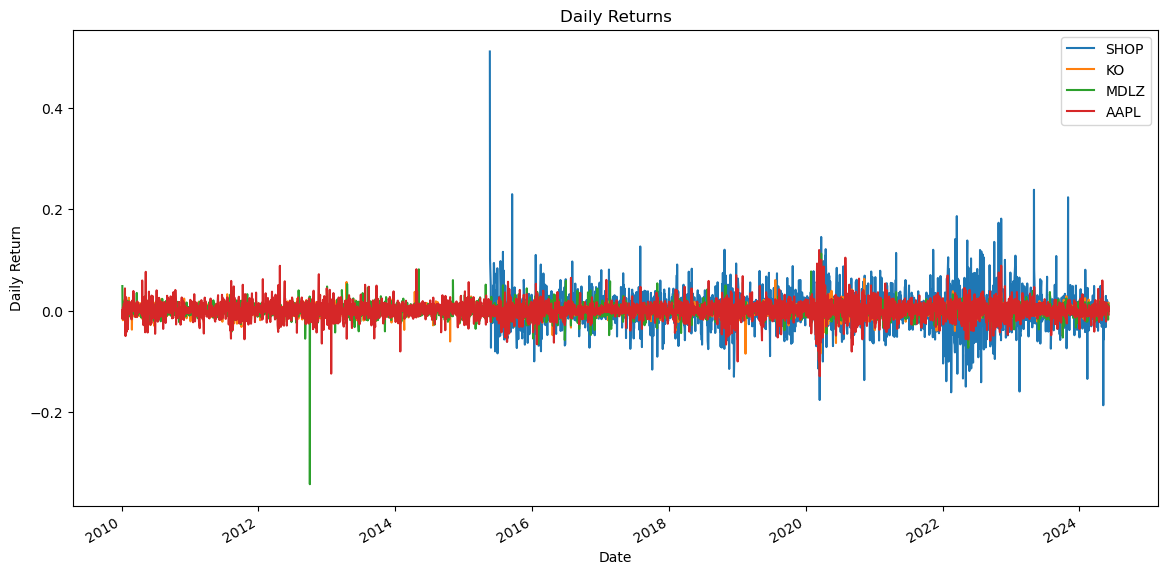

In [74]:
# Plot daily returns
plt.figure(figsize=(14, 7))
for ticker in tickers:
    returns[ticker].plot(label=ticker)
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [75]:
# Calculate moving averages
moving_averages = data.rolling(window=30).mean()
moving_averages.dropna()

Ticker,AAPL,KO,MDLZ,SHOP
Date,,,,
2015-07-01,32.133833,40.414333,40.675000,3.076133
2015-07-02,32.103666,40.352333,40.704667,3.123833
2015-07-06,32.058750,40.292000,40.736333,3.140000
2015-07-07,32.001666,40.260000,40.790000,3.148167
2015-07-08,31.942916,40.222333,40.839000,3.146633
...,...,...,...,...
2024-05-31,181.602333,62.246667,70.196000,64.728667
2024-06-03,182.570000,62.338667,70.170667,64.396334
2024-06-04,183.520333,62.451667,70.126667,64.067334


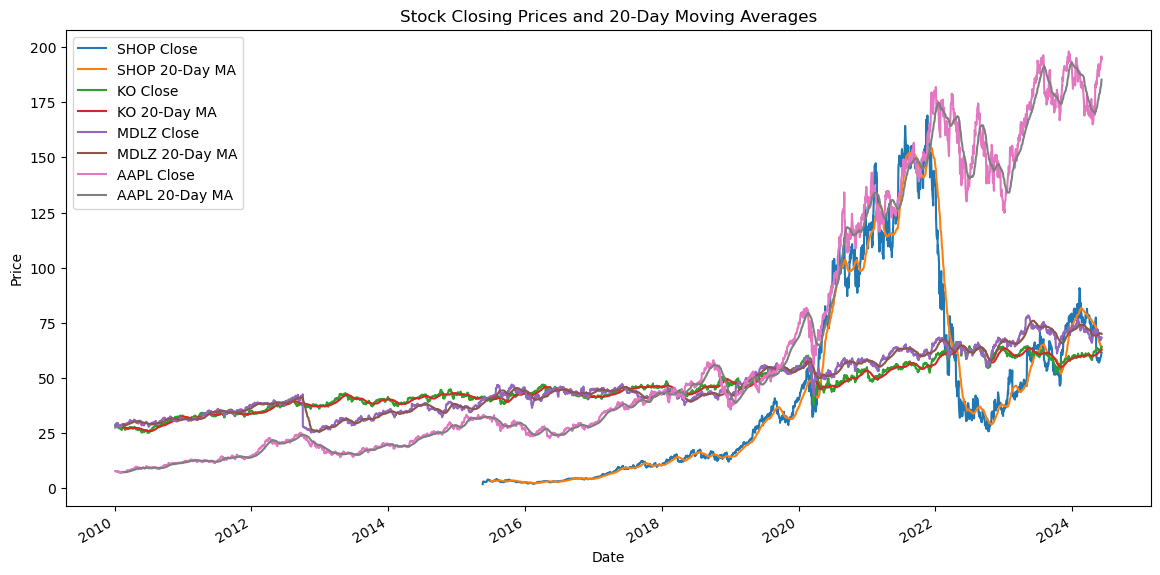

In [76]:
# Plot moving averages
plt.figure(figsize=(14, 7))
for ticker in tickers:
    data[ticker].plot(label=f'{ticker} Close')
    moving_averages[ticker].plot(label=f'{ticker} 20-Day MA')
plt.title('Stock Closing Prices and 20-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

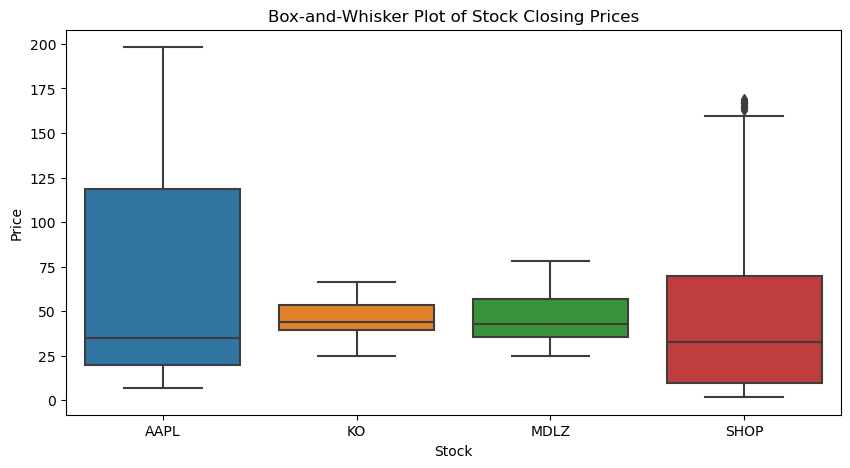

In [77]:
# Create box-and-whisker plots for closing prices
plt.figure(figsize=(10, 5))
sns.boxplot(data=data)
plt.title('Box-and-Whisker Plot of Stock Closing Prices')
plt.xlabel('Stock')
plt.ylabel('Price')
plt.show()

[*********************100%%**********************]  1 of 1 completed


SHOP Mean Squared Error: 6.715970732551818


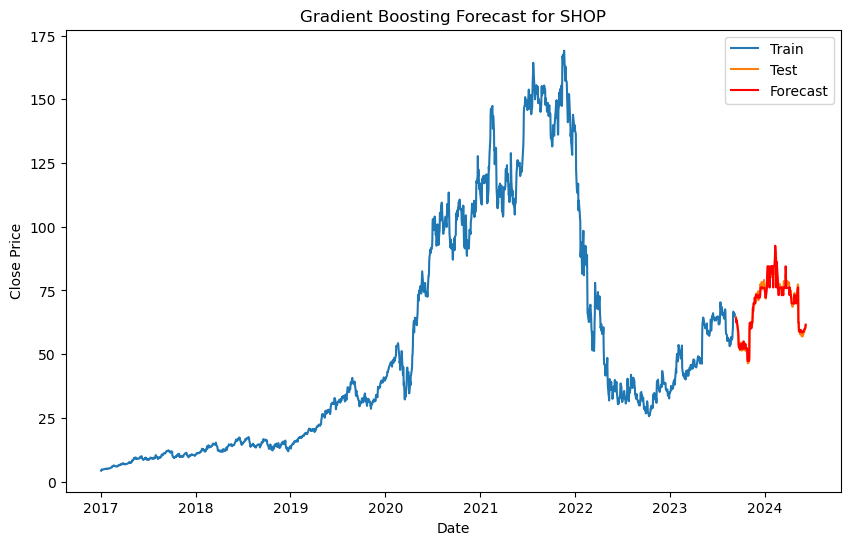

[*********************100%%**********************]  1 of 1 completed


KO Mean Squared Error: 0.29975510281359635


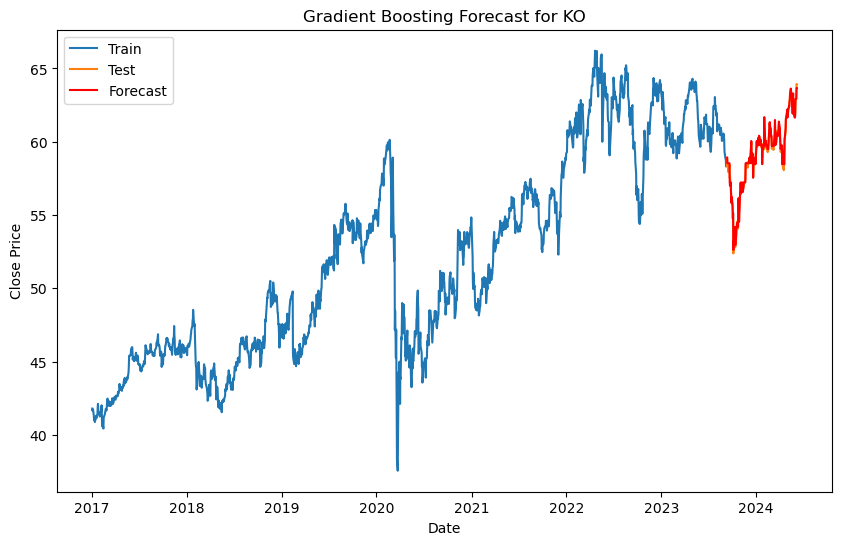

[*********************100%%**********************]  1 of 1 completed


MDLZ Mean Squared Error: 0.7777326190791148


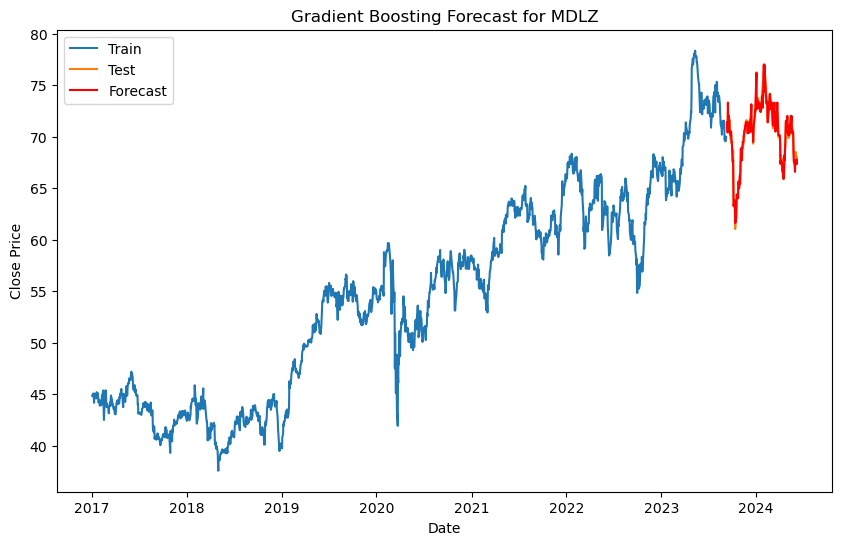

[*********************100%%**********************]  1 of 1 completed


AAPL Mean Squared Error: 8.630720187491898


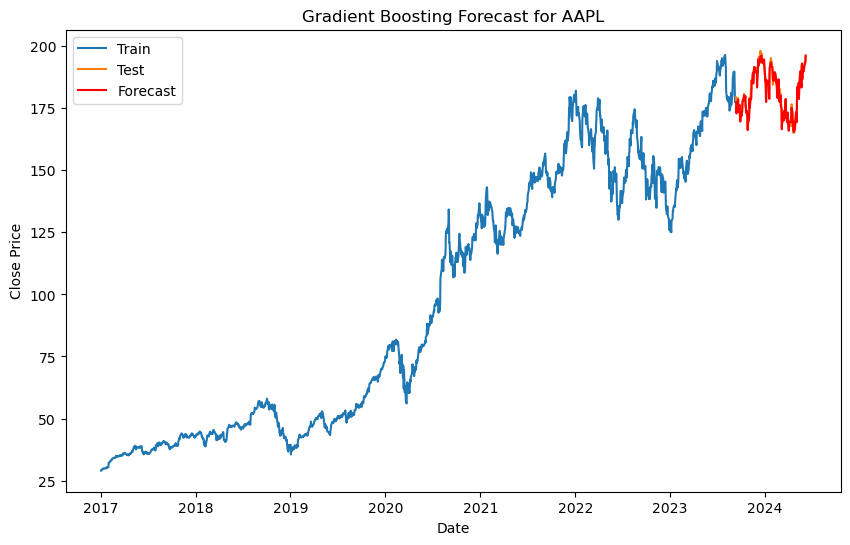

In [78]:
# creating a function to iterate through each stock and plot a predictive graph
start_date = '2017-01-01'
end_date= datetime.now()

def get_stock_data(tickers):
    stock_data = yf.download(tickers, start_date, end_date)
    stock_data = stock_data[['Close']]
    stock_data.sort_index(inplace=True)
    return stock_data

def split(stock_data):
    split_index = int(len(stock_data) * 0.9)
    train_stocks = stock_data[:split_index]
    test_stocks = stock_data[split_index:]
    return test_stocks, train_stocks

def train_model(test_stocks, train_stocks):
    train_stocks['Target'] = train_stocks['Close'].shift(-1)
    test_stocks['Target'] = test_stocks['Close'].shift(-1)
    train_stocks.dropna(inplace=True)
    test_stocks.dropna(inplace=True)

    X_train_stocks = train_stocks[['Close']]
    y_train_stocks = train_stocks['Target']
    X_test_stocks = test_stocks[['Close']]
    y_test_stocks = test_stocks['Target']

    gbm = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1)
    gbm.fit(X_train_stocks, y_train_stocks)

    return gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks

def test_model(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker):
    y_pred_stocks = gbm.predict(X_test_stocks)
    mse = mean_squared_error(y_test_stocks, y_pred_stocks)
    print(f"{ticker} Mean Squared Error: {mse}")

    plt.figure(figsize=(10, 6))
    plt.plot(train_stocks.index, train_stocks['Close'], label='Train')
    plt.plot(test_stocks.index, test_stocks['Close'], label='Test')
    plt.plot(test_stocks.index, y_pred_stocks, label='Forecast', color='red')
    plt.title(f'Gradient Boosting Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Iterate through the list of tickers
for ticker in tickers:
    stock_data = get_stock_data(ticker)
    test_stocks, train_stocks = split(stock_data)
    gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks = train_model(test_stocks, train_stocks)
    test_model(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker)

[*********************100%%**********************]  1 of 1 completed


SHOP Mean Squared Error: 6.715970732551818


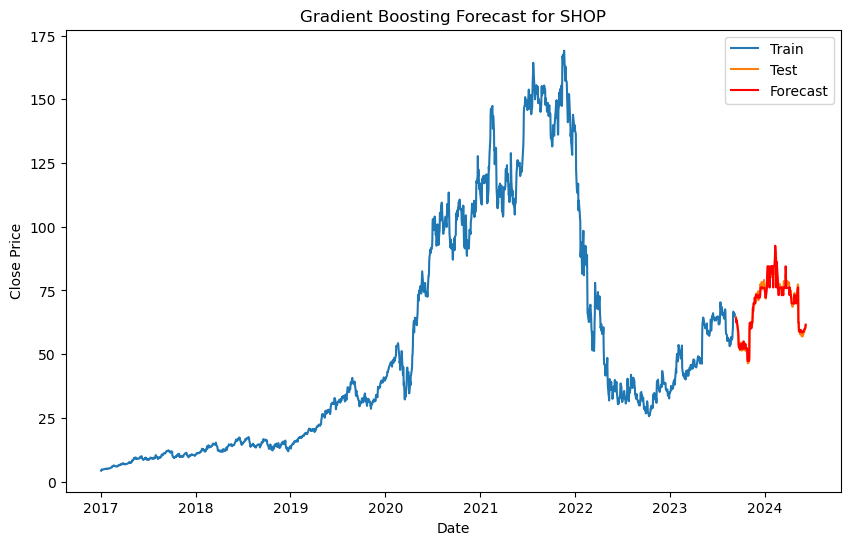

[*********************100%%**********************]  1 of 1 completed


KO Mean Squared Error: 0.29975510281359635


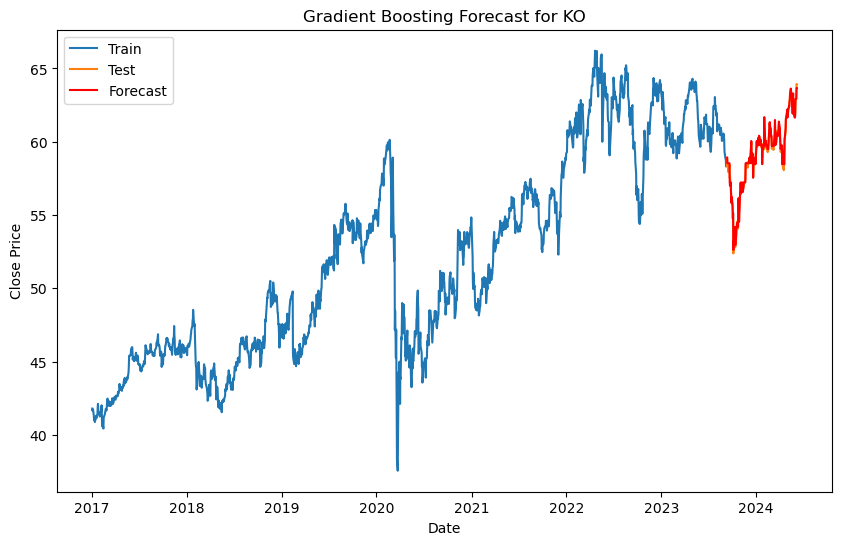

[*********************100%%**********************]  1 of 1 completed


MDLZ Mean Squared Error: 0.7777326190791148


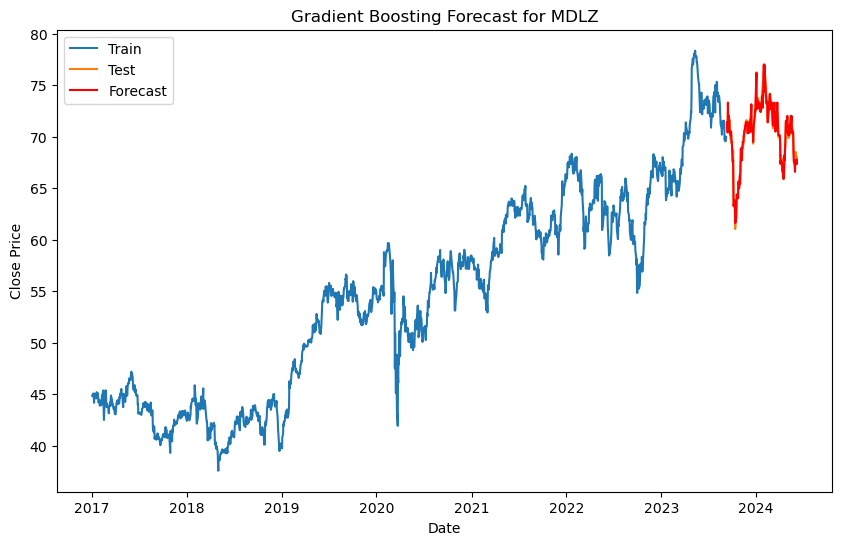

[*********************100%%**********************]  1 of 1 completed


AAPL Mean Squared Error: 8.630720187491898


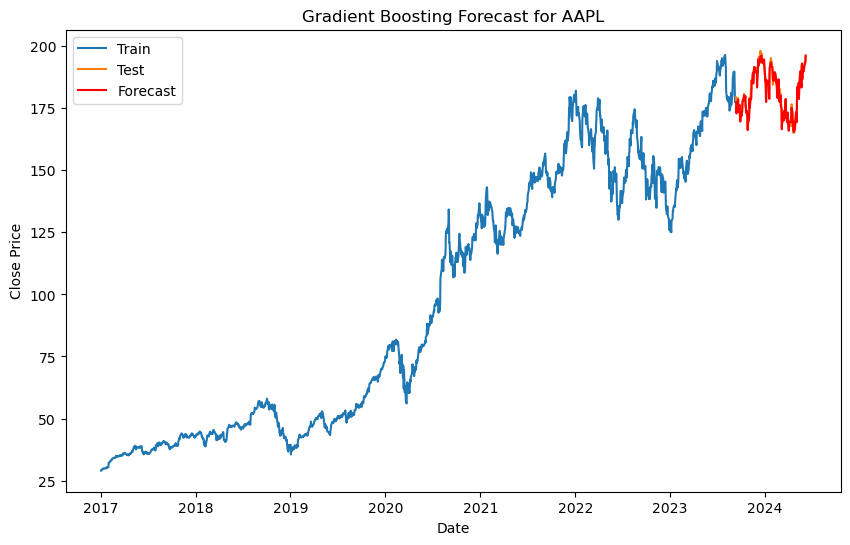

In [79]:
# creating a function to iterate through each stock and plot a predictive graph
start_date = '2017-01-01'
end_date= datetime.now()

def train_model_2(test_stocks, train_stocks):
    train_stocks['Target'] = train_stocks['Close'].shift(-1)
    test_stocks['Target'] = test_stocks['Close'].shift(-1)
    train_stocks.dropna(inplace=True)
    test_stocks.dropna(inplace=True)

    X_train_stocks = train_stocks[['Close']]
    y_train_stocks = train_stocks['Target']
    X_test_stocks = test_stocks[['Close']]
    y_test_stocks = test_stocks['Target']

    gbm = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1)
    gbm.fit(X_train_stocks, y_train_stocks)

    return gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks

def test_model_2(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker):
    y_pred_stocks = gbm.predict(X_test_stocks)
    mse = mean_squared_error(y_test_stocks, y_pred_stocks)
    print(f"{ticker} Mean Squared Error: {mse}")

    plt.figure(figsize=(10, 6))
    plt.plot(train_stocks.index, train_stocks['Close'], label='Train')
    plt.plot(test_stocks.index, test_stocks['Close'], label='Test')
    plt.plot(test_stocks.index, y_pred_stocks, label='Forecast', color='red')
    plt.title(f'Gradient Boosting Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Iterate through the list of tickers
for ticker in tickers:
    stock_data = get_stock_data(ticker)
    test_stocks, train_stocks = split(stock_data)
    gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks = train_model_2(test_stocks, train_stocks)
    test_model_2(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker)

Predicting future stock prices using GB_model_2 

In [82]:
end_date

'2024-07-01'

[*********************100%%**********************]  1 of 1 completed


SHOP Mean Squared Error: 7.869936503918868


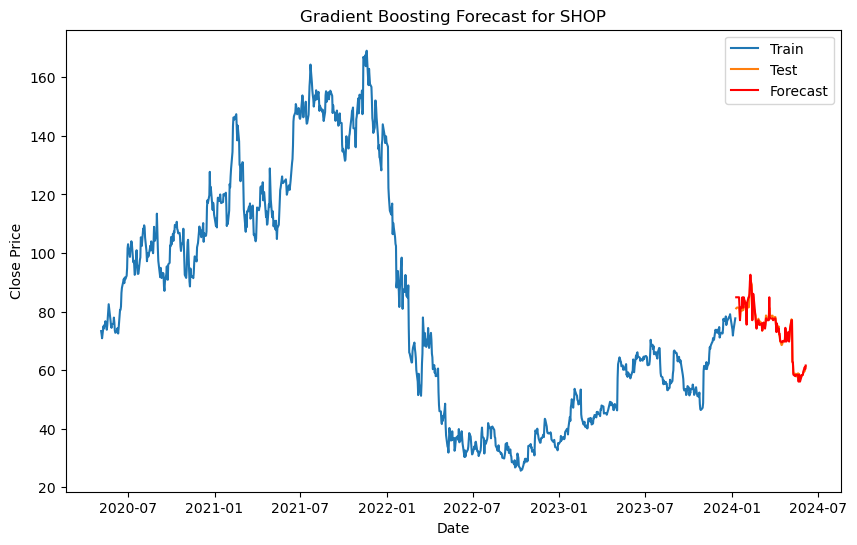

[*********************100%%**********************]  1 of 1 completed


KO Mean Squared Error: 0.2278678848530266


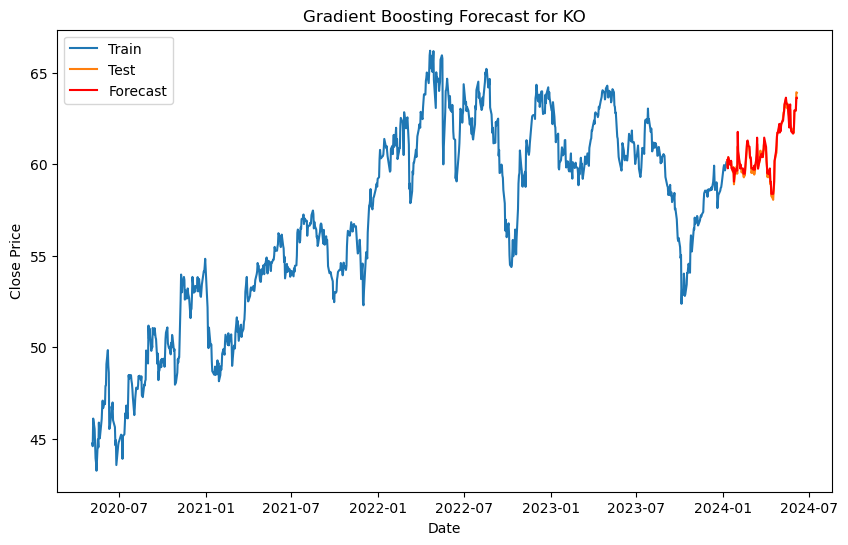

[*********************100%%**********************]  1 of 1 completed


MDLZ Mean Squared Error: 0.6821692854029744


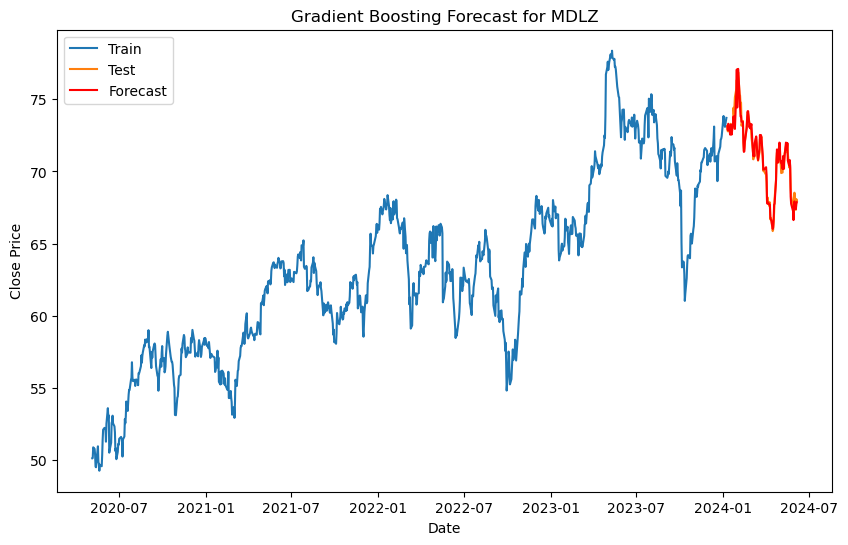

[*********************100%%**********************]  1 of 1 completed


AAPL Mean Squared Error: 7.074833556320937


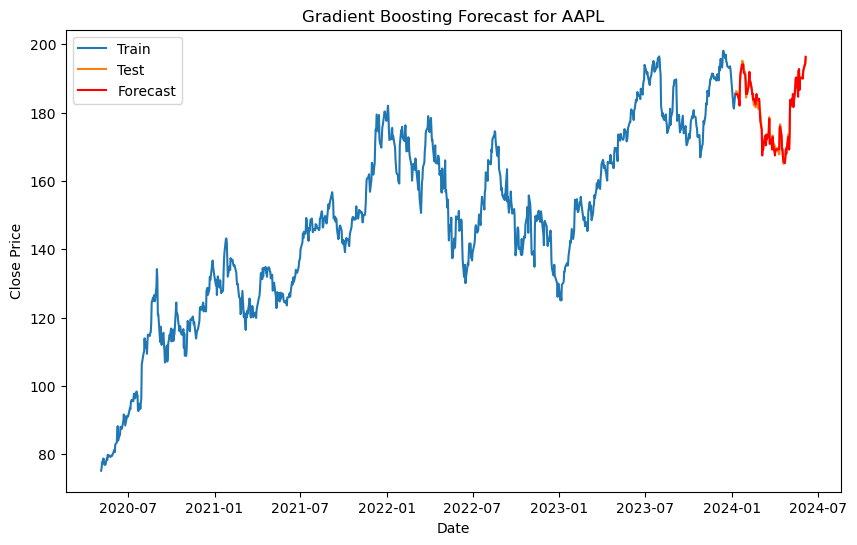

In [89]:
start_date = '2020-05-06'
end_date= '2024-07-01'

# Iterate through the list of tickers
for ticker in tickers:
    stock_data = get_stock_data(ticker)
    test_stocks, train_stocks = split(stock_data)
    gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks = train_model_2(test_stocks, train_stocks)
    test_model_2(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker)
